In [ ]:
# パッケージのimport
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from collections import defaultdict
import time

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold

from tqdm import tqdm
import gc
import copy

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import lr_scheduler

In [ ]:
class CFG:
    seed = 42
    n_fold=5
    train_bs = 128
    valid_bs = 64
    img_size = 64
    epochs = 100
    learning_rate = 1e-3
    scheduler = 'CosineAnnealingLR'
    min_lr = 1e-6
    T_max = 100
    weight_decay = 1e-8
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
df_train = pd.read_csv("/content/sample_data/mnist_train_small.csv",dtype = np.float32)
df_train.rename(columns={'6': 'label'}, inplace=True)
df_test = pd.read_csv("/content/sample_data/mnist_test.csv",dtype = np.float32)
df_test.rename(columns={'7': 'label'}, inplace=True)
# 学習データとして、1を2000枚使用する
df_train = df_train.query("label in [1.0]").head(2000)
# テストデータとして、1、0の画像を合わせて500枚使用する
df_test = df_test.query("label in [1.0, 0.0]").head(500)

In [ ]:
kf = KFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
df_train['fold']=1
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train)):
  df_train.iloc[val_idx,-1] = fold
df_train=df_train.reset_index(drop=True)

In [ ]:
class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()

    def CBA(in_channel, out_channel, kernel_size=4, stride=2, padding=1, activation=nn.ReLU(inplace=True), bn=True):
        seq = []
        seq += [nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding)]
        if bn is True:
          seq += [nn.BatchNorm2d(out_channel)]
        seq += [activation]

        return nn.Sequential(*seq)

    seq = []
    seq += [CBA(20, 64*8, stride=1, padding=0)]
    seq += [CBA(64*8, 64*4)]
    seq += [CBA(64*4, 64*2)]
    seq += [CBA(64*2, 64)]
    seq += [CBA(64, 1, activation=nn.Tanh(), bn=False)]

    self.generator_network = nn.Sequential(*seq)

  def forward(self, z):
      out = self.generator_network(z)

      return out

In [ ]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    def CBA(in_channel, out_channel, kernel_size=4, stride=2, padding=1, activation=nn.LeakyReLU(0.1, inplace=True)):
        seq = []
        seq += [nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding)]
        seq += [nn.BatchNorm2d(out_channel)]
        seq += [activation]

        return nn.Sequential(*seq)

    seq = []
    seq += [CBA(1, 64)]
    seq += [CBA(64, 64*2)]
    seq += [CBA(64*2, 64*4)]
    seq += [CBA(64*4, 64*8)]
    self.feature_network = nn.Sequential(*seq)

    self.critic_network = nn.Conv2d(64*8, 1, kernel_size=4, stride=1)

  def forward(self, x):
      out = self.feature_network(x)

      feature = out
      feature = feature.view(feature.size(0), -1)

      out = self.critic_network(out)

      return out, feature

In [ ]:
class image_data_set(Dataset):
    def __init__(self, data):
        self.images = data[:,:,:,None]
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(CFG.img_size, interpolation=Image.BICUBIC),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.transform(self.images[idx])

In [ ]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [ ]:
def train_discriminator_one_epoch(G, D, optimizerD, schedulerD, dataloader, device, epoch):
    G.train()
    D.train()

    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, images in pbar:         
        images = images.to(device)

        batch_size = images.size(0)
        
        # 真偽のラベルを定義
        label_real = torch.full((images.size(0),), 1.0).to(device)
        label_fake = torch.full((images.size(0),), 0.0).to(device)
        
        # Generator を用いて潜在変数から偽の画像を生成
        z = torch.randn(images.size(0), 20).to(device).view(images.size(0), 20, 1, 1).to(device)
        fake_images = G(z)

        # Discriminator で偽の画像と本物の画像を判定
        d_out_real, _ = D(images)
        d_out_fake, _ = D(fake_images)

        # 損失の計算
        d_loss_real = criterion(d_out_real.view(-1), label_real)
        d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
        d_loss = d_loss_real + d_loss_fake
                
        optimizerD.zero_grad()
        d_loss.backward()
        optimizerD.step()
        schedulerD.step()

        running_loss += (d_loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizerD.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

@torch.no_grad()
def valid_discriminator_one_epoch(G, D, optimizerD, dataloader, device, epoch):
    G.eval()
    D.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores_dice = []

    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, images in pbar:        
        images  = images.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        # 真偽のラベルを定義
        label_real = torch.full((images.size(0),), 1.0).to(device)
        label_fake = torch.full((images.size(0),), 0.0).to(device)
        
        # Generator を用いて潜在変数から偽の画像を生成
        z = torch.randn(images.size(0), 20).to(device).view(images.size(0), 20, 1, 1).to(device)
        fake_images = G(z)

        # Discriminator で偽の画像と本物の画像を判定
        d_out_real, _ = D(images)
        d_out_fake, _ = D(fake_images)

        # 損失の計算
        d_loss_real = criterion(d_out_real.view(-1), label_real)
        d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
        d_loss = d_loss_real + d_loss_fake

        running_loss += (d_loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizerD.param_groups[0]['lr']
        pbar.set_postfix(Epoch=epoch, valid_loss=f'{epoch_loss:0.4f}',lr=f'{current_lr:0.5f}',gpu_memory=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

In [ ]:
def train_generator_one_epoch(G, D, optimizerG, schedulerG, dataloader, device, epoch):
    G.train()
    D.train()

    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, images in pbar:         
        images = images.to(device)

        batch_size = images.size(0)

        # 真偽のラベルを定義
        label_real = torch.full((images.size(0),), 1.0).to(device)
        label_fake = torch.full((images.size(0),), 0.0).to(device)
        
         # 潜在変数から偽の画像を生成
        z = torch.randn(images.size(0), 20).to(device).view(images.size(0), 20, 1, 1).to(device)
        fake_images = G(z)

        # Discriminator によって真偽判定
        d_out_fake, _ = D(fake_images)

        # 損失の計算
        g_loss = criterion(d_out_fake.view(-1), label_real)
    
        # 誤差逆伝播法で勾配の計算、重みの更新
        optimizerG.zero_grad()
        g_loss.backward()
        optimizerG.step()
        schedulerG.step()

        running_loss += (g_loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizerG.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

@torch.no_grad()
def valid_generator_one_epoch(G, D, optimizerG, dataloader, device, epoch):
    G.eval()
    D.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores_dice = []

    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, images in pbar:        
        images  = images.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        # 真偽のラベルを定義
        label_real = torch.full((images.size(0),), 1.0).to(device)
        label_fake = torch.full((images.size(0),), 0.0).to(device)
        
        # 潜在変数から偽の画像を生成
        z = torch.randn(images.size(0), 20).to(device).view(images.size(0), 20, 1, 1).to(device)
        fake_images = G(z)

        # Discriminator によって真偽判定
        d_out_fake, _ = D(fake_images)

        # 損失の計算
        g_loss = criterion(d_out_fake.view(-1), label_real)
    

        running_loss += (g_loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizerG.param_groups[0]['lr']
        pbar.set_postfix(Epoch=epoch, valid_loss=f'{epoch_loss:0.4f}',lr=f'{current_lr:0.5f}',gpu_memory=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

In [ ]:
def run_training(G, D, optimizerG, optimizerD, schedulerG, schedulerD, device, num_epochs,fold):
    # To automatically log gradients
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts_G = copy.deepcopy(G.state_dict())
    best_epoch_loss_G = np.inf
    best_model_wts_D = copy.deepcopy(D.state_dict())
    best_epoch_loss_D = np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(CFG.epochs): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_dis_loss = train_discriminator_one_epoch(G, D, optimizerD, schedulerD, dataloader=train_loader, device=CFG.device, epoch=epoch)
        train_gen_loss = train_generator_one_epoch(G, D, optimizerG, schedulerG, dataloader=train_loader, device=CFG.device, epoch=epoch)

        valid_dis_loss = valid_discriminator_one_epoch(G, D, optimizerD, dataloader=valid_loader, device=CFG.device, epoch=epoch)
        valid_gen_loss = valid_generator_one_epoch(G, D, optimizerG, dataloader=valid_loader, device=CFG.device, epoch=epoch)

        

        history['Train Dis Loss'].append(train_dis_loss)
        history['Train Gen Loss'].append(train_gen_loss)
        history['Valid Dis Loss'].append(valid_dis_loss)
        history['Valid Gen Loss'].append(valid_gen_loss)
        
        
        print('Valid Disctiminator Loss')
        print(valid_dis_loss)
        print('Valid Generator Loss')
        print(valid_gen_loss)

        # deep copy the model
        if valid_dis_loss <= best_epoch_loss_D:
          print(f"d Loss Improved ({best_epoch_loss_D} ---> {valid_dis_loss})")
          best_epoch_loss_D = valid_dis_loss
          best_model_wts_D = copy.deepcopy(D.state_dict())
          DPATH = f"D_model_fold{fold}.bin"
          torch.save(D.state_dict(), DPATH)
          # Save a model file from the current directory
          print(f"D_Model Saved")

        if valid_gen_loss <= best_epoch_loss_G:
          print(f"g Loss Improved ({best_epoch_loss_G} ---> {valid_gen_loss})")
          best_epoch_loss_G = valid_gen_loss
          best_model_wts_G = copy.deepcopy(G.state_dict())
          GPATH = f"G_model_fold{fold}.bin"
          torch.save(G.state_dict(), GPATH)
          # Save a model file from the current directory
          print(f"G_Model Saved")

        
        #if you need save last model
        last_model_wts_D = copy.deepcopy(D.state_dict())
        PATH = f"D_last_model_fold{fold}.bin"
        torch.save(D.state_dict(), PATH)

        last_model_wts_G = copy.deepcopy(G.state_dict())
        PATH = f"G_last_model_fold{fold}.bin"
        torch.save(G.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print('Best Discriminator Loss')
    print(format,best_epoch_loss_D)
    print('Best Generator Loss')
    print(format,best_epoch_loss_G)
    
    # load best model weights
    G.load_state_dict(best_model_wts_G)
    D.load_state_dict(best_model_wts_D)
    
    return G, D, history

In [ ]:
def prepare_loaders(fold, df):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    # ラベル(1列目)を削除
    train = train_df.iloc[:,1:-1].values.astype('float32')
    valid = valid_df.iloc[:,1:-1].values.astype('float32')

    # 28×28 の行列に変換
    train = train.reshape(train.shape[0], 28, 28)
    valid = valid.reshape(valid.shape[0], 28, 28)

    train_dataset = image_data_set(train)
    valid_dataset = image_data_set(valid)

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, shuffle=True)
    
    return train_loader, valid_loader

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/GAN/ano_model_change

/content/drive/MyDrive/Colab Notebooks/GAN/ano_model_change


In [ ]:
for fold in range(1):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)

    # GPU or CPU の指定
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    G = Generator().to(device)
    D = Discriminator().to(device)
    train_loader, valid_loader = prepare_loaders(fold=fold, df=df_train)
    optimizerG = torch.optim.AdamW(G.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)
    optimizerD = torch.optim.AdamW(D.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)
    schedulerG = fetch_scheduler(optimizerG)
    schedulerD = fetch_scheduler(optimizerD)
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    G, D, history = run_training(G, D, optimizerG, optimizerD, schedulerG, schedulerD, device=CFG.device, num_epochs=CFG.epochs, fold=fold)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


###############
### Fold: 0
###############
cuda: Tesla T4

Epoch 0/100

100%|██████████| 13/13 [00:00<00:00, 16.98it/s, Epoch=0, gpu_memory=1.15 GB, lr=0.00096, valid_loss=5.2323]


Valid Disctiminator Loss
0.005357160400599241
Valid Generator Loss
5.232333297729492
d Loss Improved (inf ---> 0.005357160400599241)
D_Model Saved
g Loss Improved (inf ---> 5.232333297729492)
G_Model Saved


Epoch 1/100

100%|██████████| 13/13 [00:00<00:00, 16.66it/s, Epoch=1, gpu_memory=1.15 GB, lr=0.00084, valid_loss=6.2148]


Valid Disctiminator Loss
0.05334273809567094
Valid Generator Loss
6.2148174285888675


Epoch 2/100

100%|██████████| 13/13 [00:00<00:00, 16.49it/s, Epoch=2, gpu_memory=1.15 GB, lr=0.00067, valid_loss=5.9967]


Valid Disctiminator Loss
0.09816845061257481
Valid Generator Loss
5.996685466766357


Epoch 3/100

100%|██████████| 13/13 [00:00<00:00, 16.69it/s, Epoch=3, gpu_memory=1.16 GB, lr=0.00047, valid_loss=5.2370]


Valid Disctiminator Loss
0.04802605077624321
Valid Generator Loss
5.237021389007569


Epoch 4/100

100%|██████████| 13/13 [00:00<00:00, 16.86it/s, Epoch=4, gpu_memory=1.15 GB, lr=0.00027, valid_loss=10.9425]


Valid Disctiminator Loss
1.0169697737693786
Valid Generator Loss
10.942463302612305


Epoch 5/100

100%|██████████| 13/13 [00:00<00:00, 17.05it/s, Epoch=5, gpu_memory=1.16 GB, lr=0.00012, valid_loss=8.2007]


Valid Disctiminator Loss
0.2429483690019697
Valid Generator Loss
8.200674896240235


Epoch 6/100

100%|██████████| 13/13 [00:00<00:00, 17.17it/s, Epoch=6, gpu_memory=1.15 GB, lr=0.00002, valid_loss=11.0281]


Valid Disctiminator Loss
0.5095190708339215
Valid Generator Loss
11.028062744140625


Epoch 7/100

100%|██████████| 13/13 [00:00<00:00, 17.22it/s, Epoch=7, gpu_memory=1.15 GB, lr=0.00000, valid_loss=11.0763]


Valid Disctiminator Loss
0.5141325435042381
Valid Generator Loss
11.07632381439209


Epoch 8/100

100%|██████████| 13/13 [00:00<00:00, 17.24it/s, Epoch=8, gpu_memory=1.15 GB, lr=0.00007, valid_loss=11.0853]


Valid Disctiminator Loss
0.47176361829042435
Valid Generator Loss
11.085265502929687


Epoch 9/100

100%|██████████| 13/13 [00:00<00:00, 17.06it/s, Epoch=9, gpu_memory=1.16 GB, lr=0.00021, valid_loss=11.0428]


Valid Disctiminator Loss
0.3367632458359003
Valid Generator Loss
11.042827529907226


Epoch 10/100

100%|██████████| 13/13 [00:00<00:00, 16.85it/s, Epoch=10, gpu_memory=1.15 GB, lr=0.00039, valid_loss=16.4784]


Valid Disctiminator Loss
0.3965347787737846
Valid Generator Loss
16.47838409423828


Epoch 11/100

100%|██████████| 13/13 [00:00<00:00, 17.02it/s, Epoch=11, gpu_memory=1.16 GB, lr=0.00059, valid_loss=9.5995]


Valid Disctiminator Loss
0.07989303473790642
Valid Generator Loss
9.599509239196777


Epoch 12/100

100%|██████████| 13/13 [00:00<00:00, 16.36it/s, Epoch=12, gpu_memory=1.15 GB, lr=0.00078, valid_loss=9.3789]


Valid Disctiminator Loss
0.09577311118424404
Valid Generator Loss
9.378857612609863


Epoch 13/100

100%|██████████| 13/13 [00:00<00:00, 16.45it/s, Epoch=13, gpu_memory=1.15 GB, lr=0.00092, valid_loss=3.9318]


Valid Disctiminator Loss
0.04848249733448028
Valid Generator Loss
3.9318492889404295
g Loss Improved (5.232333297729492 ---> 3.9318492889404295)
G_Model Saved


Epoch 14/100

100%|██████████| 13/13 [00:00<00:00, 17.10it/s, Epoch=14, gpu_memory=1.15 GB, lr=0.00099, valid_loss=12.9097]


Valid Disctiminator Loss
0.12138844700182744
Valid Generator Loss
12.909732055664062


Epoch 15/100

100%|██████████| 13/13 [00:00<00:00, 16.96it/s, Epoch=15, gpu_memory=1.15 GB, lr=0.00098, valid_loss=7.3829]


Valid Disctiminator Loss
0.029594915034249426
Valid Generator Loss
7.382862091064453


Epoch 16/100

100%|██████████| 13/13 [00:00<00:00, 17.53it/s, Epoch=16, gpu_memory=1.15 GB, lr=0.00090, valid_loss=14.2751]


Valid Disctiminator Loss
0.0584181016004004
Valid Generator Loss
14.275073623657226


Epoch 17/100

100%|██████████| 13/13 [00:00<00:00, 17.77it/s, Epoch=17, gpu_memory=1.15 GB, lr=0.00074, valid_loss=5.2690]


Valid Disctiminator Loss
0.01556325202807784
Valid Generator Loss
5.269049530029297


Epoch 18/100

100%|██████████| 13/13 [00:00<00:00, 16.92it/s, Epoch=18, gpu_memory=1.15 GB, lr=0.00055, valid_loss=7.5516]


Valid Disctiminator Loss
0.1255042603611946
Valid Generator Loss
7.551562004089355


Epoch 19/100

100%|██████████| 13/13 [00:00<00:00, 16.72it/s, Epoch=19, gpu_memory=1.15 GB, lr=0.00035, valid_loss=4.8497]


Valid Disctiminator Loss
0.04355063747614622
Valid Generator Loss
4.849653072357178


Epoch 20/100

100%|██████████| 13/13 [00:00<00:00, 17.46it/s, Epoch=20, gpu_memory=1.15 GB, lr=0.00017, valid_loss=9.0801]


Valid Disctiminator Loss
0.4003956490755081
Valid Generator Loss
9.08014045715332


Epoch 21/100

100%|██████████| 13/13 [00:00<00:00, 17.29it/s, Epoch=21, gpu_memory=1.15 GB, lr=0.00005, valid_loss=7.4266]


Valid Disctiminator Loss
0.16626892864704132
Valid Generator Loss
7.426567077636719


Epoch 22/100

100%|██████████| 13/13 [00:00<00:00, 17.61it/s, Epoch=22, gpu_memory=1.15 GB, lr=0.00000, valid_loss=6.9386]


Valid Disctiminator Loss
0.13861900225281715
Valid Generator Loss
6.938559036254883


Epoch 23/100

100%|██████████| 13/13 [00:00<00:00, 16.25it/s, Epoch=23, gpu_memory=1.15 GB, lr=0.00004, valid_loss=6.8249]


Valid Disctiminator Loss
0.13071628324687481
Valid Generator Loss
6.824850883483887


Epoch 24/100

100%|██████████| 13/13 [00:00<00:00, 14.93it/s, Epoch=24, gpu_memory=1.15 GB, lr=0.00015, valid_loss=6.5638]


Valid Disctiminator Loss
0.09696654800325633
Valid Generator Loss
6.563817501068115


Epoch 25/100

100%|██████████| 13/13 [00:00<00:00, 17.14it/s, Epoch=25, gpu_memory=1.15 GB, lr=0.00032, valid_loss=7.1637]


Valid Disctiminator Loss
0.07311693755909801
Valid Generator Loss
7.163671684265137


Epoch 26/100

100%|██████████| 13/13 [00:00<00:00, 16.91it/s, Epoch=26, gpu_memory=1.15 GB, lr=0.00052, valid_loss=14.2216]


Valid Disctiminator Loss
0.17546653017401695
Valid Generator Loss
14.221598663330077


Epoch 27/100

100%|██████████| 13/13 [00:00<00:00, 17.27it/s, Epoch=27, gpu_memory=1.15 GB, lr=0.00071, valid_loss=11.6533]


Valid Disctiminator Loss
0.04714612844567455
Valid Generator Loss
11.653347549438477


Epoch 28/100

100%|██████████| 13/13 [00:00<00:00, 16.65it/s, Epoch=28, gpu_memory=1.15 GB, lr=0.00088, valid_loss=14.3271]


Valid Disctiminator Loss
0.24461385548114778
Valid Generator Loss
14.327084579467773


Epoch 29/100

100%|██████████| 13/13 [00:00<00:00, 17.36it/s, Epoch=29, gpu_memory=1.15 GB, lr=0.00098, valid_loss=18.5103]


Valid Disctiminator Loss
0.10463224545121193
Valid Generator Loss
18.5102555847168


Epoch 30/100

100%|██████████| 13/13 [00:00<00:00, 17.05it/s, Epoch=30, gpu_memory=1.15 GB, lr=0.00100, valid_loss=20.6302]


Valid Disctiminator Loss
0.306469292640686
Valid Generator Loss
20.630150833129882


Epoch 31/100

100%|██████████| 13/13 [00:00<00:00, 16.19it/s, Epoch=31, gpu_memory=1.15 GB, lr=0.00094, valid_loss=11.0560]


Valid Disctiminator Loss
0.02045416041459248
Valid Generator Loss
11.05598876953125


Epoch 32/100

100%|██████████| 13/13 [00:00<00:00, 17.31it/s, Epoch=32, gpu_memory=1.15 GB, lr=0.00081, valid_loss=10.4279]


Valid Disctiminator Loss
0.008701452321693068
Valid Generator Loss
10.42785171508789


Epoch 33/100

100%|██████████| 13/13 [00:00<00:00, 17.18it/s, Epoch=33, gpu_memory=1.15 GB, lr=0.00062, valid_loss=17.8664]


Valid Disctiminator Loss
0.024857572519686073
Valid Generator Loss
17.86638214111328


Epoch 34/100

100%|██████████| 13/13 [00:00<00:00, 16.18it/s, Epoch=34, gpu_memory=1.15 GB, lr=0.00042, valid_loss=15.8689]


Valid Disctiminator Loss
0.07738158130086958
Valid Generator Loss
15.86894561767578


Epoch 35/100

100%|██████████| 13/13 [00:00<00:00, 16.54it/s, Epoch=35, gpu_memory=1.15 GB, lr=0.00023, valid_loss=18.2099]


Valid Disctiminator Loss
0.03033224011829587
Valid Generator Loss
18.209881591796876


Epoch 36/100

100%|██████████| 13/13 [00:00<00:00, 17.42it/s, Epoch=36, gpu_memory=1.15 GB, lr=0.00009, valid_loss=23.8637]


Valid Disctiminator Loss
0.6625340390205383
Valid Generator Loss
23.863690185546876


Epoch 37/100

100%|██████████| 13/13 [00:01<00:00, 11.69it/s, Epoch=37, gpu_memory=1.15 GB, lr=0.00001, valid_loss=22.4174]


Valid Disctiminator Loss
0.17982951581478118
Valid Generator Loss
22.41736198425293


Epoch 38/100

100%|██████████| 13/13 [00:00<00:00, 16.11it/s, Epoch=38, gpu_memory=1.15 GB, lr=0.00001, valid_loss=22.5596]


Valid Disctiminator Loss
0.15604952920228243
Valid Generator Loss
22.559577255249025


Epoch 39/100

100%|██████████| 13/13 [00:00<00:00, 16.78it/s, Epoch=39, gpu_memory=1.15 GB, lr=0.00010, valid_loss=22.2712]


Valid Disctiminator Loss
0.11513167262077331
Valid Generator Loss
22.271237869262695


Epoch 40/100

100%|██████████| 13/13 [00:00<00:00, 16.42it/s, Epoch=40, gpu_memory=1.15 GB, lr=0.00025, valid_loss=24.4949]


Valid Disctiminator Loss
0.07637699183062069
Valid Generator Loss
24.494918441772462


Epoch 41/100

100%|██████████| 13/13 [00:00<00:00, 17.18it/s, Epoch=41, gpu_memory=1.15 GB, lr=0.00044, valid_loss=27.0520]


Valid Disctiminator Loss
0.029932702217781753
Valid Generator Loss
27.05196044921875


Epoch 42/100

100%|██████████| 13/13 [00:00<00:00, 16.57it/s, Epoch=42, gpu_memory=1.15 GB, lr=0.00064, valid_loss=25.4523]


Valid Disctiminator Loss
0.01025305683091005
Valid Generator Loss
25.45230438232422


Epoch 43/100

100%|██████████| 13/13 [00:00<00:00, 17.20it/s, Epoch=43, gpu_memory=1.15 GB, lr=0.00082, valid_loss=13.5491]


Valid Disctiminator Loss
0.0008997437979178358
Valid Generator Loss
13.549092407226562
d Loss Improved (0.005357160400599241 ---> 0.0008997437979178358)
D_Model Saved


Epoch 44/100

100%|██████████| 13/13 [00:00<00:00, 15.55it/s, Epoch=44, gpu_memory=1.15 GB, lr=0.00095, valid_loss=9.5075]


Valid Disctiminator Loss
0.00033661217312328515
Valid Generator Loss
9.507545928955079
d Loss Improved (0.0008997437979178358 ---> 0.00033661217312328515)
D_Model Saved


Epoch 45/100

100%|██████████| 13/13 [00:00<00:00, 16.84it/s, Epoch=45, gpu_memory=1.15 GB, lr=0.00100, valid_loss=10.2989]


Valid Disctiminator Loss
0.005582923367328476
Valid Generator Loss
10.298906707763672


Epoch 46/100

100%|██████████| 13/13 [00:00<00:00, 17.03it/s, Epoch=46, gpu_memory=1.15 GB, lr=0.00097, valid_loss=8.3616]


Valid Disctiminator Loss
0.0011135713563999161
Valid Generator Loss
8.361647987365723


Epoch 47/100

100%|██████████| 13/13 [00:00<00:00, 17.05it/s, Epoch=47, gpu_memory=1.15 GB, lr=0.00086, valid_loss=6.2623]


Valid Disctiminator Loss
0.0019284964259713888
Valid Generator Loss
6.262333850860596


Epoch 48/100

100%|██████████| 13/13 [00:00<00:00, 16.87it/s, Epoch=48, gpu_memory=1.15 GB, lr=0.00070, valid_loss=8.8973]


Valid Disctiminator Loss
0.07001171363750473
Valid Generator Loss
8.897324676513671


Epoch 49/100

100%|██████████| 13/13 [00:00<00:00, 17.11it/s, Epoch=49, gpu_memory=1.15 GB, lr=0.00050, valid_loss=12.4564]


Valid Disctiminator Loss
0.14972405575215816
Valid Generator Loss
12.456360893249512


Epoch 50/100

100%|██████████| 13/13 [00:00<00:00, 16.92it/s, Epoch=50, gpu_memory=1.15 GB, lr=0.00030, valid_loss=13.3588]


Valid Disctiminator Loss
0.19788216680288315
Valid Generator Loss
13.358811912536622


Epoch 51/100

100%|██████████| 13/13 [00:00<00:00, 16.95it/s, Epoch=51, gpu_memory=1.15 GB, lr=0.00014, valid_loss=12.6352]


Valid Disctiminator Loss
0.2504729034751654
Valid Generator Loss
12.635218582153321


Epoch 52/100

100%|██████████| 13/13 [00:00<00:00, 16.98it/s, Epoch=52, gpu_memory=1.15 GB, lr=0.00003, valid_loss=13.6540]


Valid Disctiminator Loss
0.37810882210731506
Valid Generator Loss
13.653989219665528


Epoch 53/100

100%|██████████| 13/13 [00:00<00:00, 17.31it/s, Epoch=53, gpu_memory=1.15 GB, lr=0.00000, valid_loss=13.6516]


Valid Disctiminator Loss
0.3374003118276596
Valid Generator Loss
13.651562042236328


Epoch 54/100

100%|██████████| 13/13 [00:00<00:00, 17.05it/s, Epoch=54, gpu_memory=1.15 GB, lr=0.00006, valid_loss=14.4058]


Valid Disctiminator Loss
0.4978236734867096
Valid Generator Loss
14.40584945678711


Epoch 55/100

100%|██████████| 13/13 [00:00<00:00, 16.43it/s, Epoch=55, gpu_memory=1.15 GB, lr=0.00018, valid_loss=14.1311]


Valid Disctiminator Loss
0.21620043605566025
Valid Generator Loss
14.131087112426759


Epoch 56/100

100%|██████████| 13/13 [00:00<00:00, 16.67it/s, Epoch=56, gpu_memory=1.15 GB, lr=0.00036, valid_loss=14.4548]


Valid Disctiminator Loss
0.12938200489617885
Valid Generator Loss
14.454750595092774


Epoch 57/100

100%|██████████| 13/13 [00:00<00:00, 16.97it/s, Epoch=57, gpu_memory=1.15 GB, lr=0.00056, valid_loss=14.8329]


Valid Disctiminator Loss
0.040579239437829526
Valid Generator Loss
14.832856636047364


Epoch 58/100

100%|██████████| 13/13 [00:00<00:00, 17.30it/s, Epoch=58, gpu_memory=1.15 GB, lr=0.00075, valid_loss=11.8305]


Valid Disctiminator Loss
0.005023186455437098
Valid Generator Loss
11.830495185852051


Epoch 59/100

100%|██████████| 13/13 [00:00<00:00, 17.07it/s, Epoch=59, gpu_memory=1.15 GB, lr=0.00090, valid_loss=9.0563]


Valid Disctiminator Loss
0.07168109329417348
Valid Generator Loss
9.05634422302246


Epoch 60/100

100%|██████████| 13/13 [00:00<00:00, 17.08it/s, Epoch=60, gpu_memory=1.15 GB, lr=0.00099, valid_loss=6.5950]


Valid Disctiminator Loss
0.0021841931343078613
Valid Generator Loss
6.595026054382324


Epoch 61/100

100%|██████████| 13/13 [00:00<00:00, 17.07it/s, Epoch=61, gpu_memory=1.15 GB, lr=0.00099, valid_loss=6.2888]


Valid Disctiminator Loss
0.006002628398127854
Valid Generator Loss
6.288764381408692


Epoch 62/100

100%|██████████| 13/13 [00:00<00:00, 17.43it/s, Epoch=62, gpu_memory=1.15 GB, lr=0.00091, valid_loss=6.6275]


Valid Disctiminator Loss
0.023163052280433475
Valid Generator Loss
6.627485504150391


Epoch 63/100

100%|██████████| 13/13 [00:00<00:00, 17.01it/s, Epoch=63, gpu_memory=1.15 GB, lr=0.00077, valid_loss=6.2640]


Valid Disctiminator Loss
0.016522399289533495
Valid Generator Loss
6.264041996002197


Epoch 64/100

100%|██████████| 13/13 [00:00<00:00, 17.25it/s, Epoch=64, gpu_memory=1.15 GB, lr=0.00058, valid_loss=7.3644]


Valid Disctiminator Loss
0.6135588479042053
Valid Generator Loss
7.364408435821534


Epoch 65/100

100%|██████████| 13/13 [00:00<00:00, 16.42it/s, Epoch=65, gpu_memory=1.15 GB, lr=0.00038, valid_loss=8.4809]


Valid Disctiminator Loss
0.5207938885688782
Valid Generator Loss
8.480907592773438


Epoch 66/100

100%|██████████| 13/13 [00:00<00:00, 17.09it/s, Epoch=66, gpu_memory=1.15 GB, lr=0.00019, valid_loss=9.3048]


Valid Disctiminator Loss
0.1666085422039032
Valid Generator Loss
9.304774017333985


Epoch 67/100

100%|██████████| 13/13 [00:00<00:00, 16.89it/s, Epoch=67, gpu_memory=1.15 GB, lr=0.00006, valid_loss=10.7084]


Valid Disctiminator Loss
0.43419883131980896
Valid Generator Loss
10.708375282287598


Epoch 68/100

100%|██████████| 13/13 [00:00<00:00, 16.41it/s, Epoch=68, gpu_memory=1.15 GB, lr=0.00000, valid_loss=10.0375]


Valid Disctiminator Loss
0.19557549476623534
Valid Generator Loss
10.037518882751465


Epoch 69/100

100%|██████████| 13/13 [00:00<00:00, 17.20it/s, Epoch=69, gpu_memory=1.15 GB, lr=0.00003, valid_loss=10.5885]


Valid Disctiminator Loss
0.17887121945619583
Valid Generator Loss
10.58850772857666


Epoch 70/100

100%|██████████| 13/13 [00:00<00:00, 16.95it/s, Epoch=70, gpu_memory=1.15 GB, lr=0.00013, valid_loss=10.8775]


Valid Disctiminator Loss
0.17337652981281282
Valid Generator Loss
10.877536239624023


Epoch 71/100

100%|██████████| 13/13 [00:00<00:00, 17.19it/s, Epoch=71, gpu_memory=1.15 GB, lr=0.00029, valid_loss=11.5996]


Valid Disctiminator Loss
0.0647715175896883
Valid Generator Loss
11.599623718261718


Epoch 72/100

100%|██████████| 13/13 [00:00<00:00, 16.53it/s, Epoch=72, gpu_memory=1.15 GB, lr=0.00048, valid_loss=11.8016]


Valid Disctiminator Loss
0.020525318392101324
Valid Generator Loss
11.80155990600586


Epoch 73/100

100%|██████████| 13/13 [00:00<00:00, 16.28it/s, Epoch=73, gpu_memory=1.15 GB, lr=0.00068, valid_loss=12.0875]


Valid Disctiminator Loss
0.025822001575215837
Valid Generator Loss
12.087528915405274


Epoch 74/100

100%|██████████| 13/13 [00:00<00:00, 16.29it/s, Epoch=74, gpu_memory=1.15 GB, lr=0.00085, valid_loss=9.2847]


Valid Disctiminator Loss
0.040604778602719306
Valid Generator Loss
9.284657974243164


Epoch 75/100

100%|██████████| 13/13 [00:00<00:00, 16.49it/s, Epoch=75, gpu_memory=1.15 GB, lr=0.00096, valid_loss=5.8628]


Valid Disctiminator Loss
0.011479720715433359
Valid Generator Loss
5.86284854888916


Epoch 76/100

100%|██████████| 13/13 [00:00<00:00, 17.18it/s, Epoch=76, gpu_memory=1.15 GB, lr=0.00100, valid_loss=5.2883]


Valid Disctiminator Loss
0.005071718264371156
Valid Generator Loss
5.288305969238281


Epoch 77/100

100%|██████████| 13/13 [00:00<00:00, 17.09it/s, Epoch=77, gpu_memory=1.15 GB, lr=0.00095, valid_loss=5.3397]


Valid Disctiminator Loss
0.07117681637406349
Valid Generator Loss
5.339718837738037


Epoch 78/100

100%|██████████| 13/13 [00:00<00:00, 17.32it/s, Epoch=78, gpu_memory=1.15 GB, lr=0.00083, valid_loss=5.8863]


Valid Disctiminator Loss
0.03566745936870575
Valid Generator Loss
5.886276359558106


Epoch 79/100

100%|██████████| 13/13 [00:00<00:00, 17.02it/s, Epoch=79, gpu_memory=1.15 GB, lr=0.00065, valid_loss=5.3499]


Valid Disctiminator Loss
0.5139633417129517
Valid Generator Loss
5.3499392318725585


Epoch 80/100

100%|██████████| 13/13 [00:00<00:00, 17.14it/s, Epoch=80, gpu_memory=1.15 GB, lr=0.00045, valid_loss=5.8375]


Valid Disctiminator Loss
2.407524585723877
Valid Generator Loss
5.837547645568848


Epoch 81/100

100%|██████████| 13/13 [00:00<00:00, 17.13it/s, Epoch=81, gpu_memory=1.15 GB, lr=0.00026, valid_loss=6.8874]


Valid Disctiminator Loss
1.3599819707870484
Valid Generator Loss
6.88739860534668


Epoch 82/100

100%|██████████| 13/13 [00:00<00:00, 16.65it/s, Epoch=82, gpu_memory=1.15 GB, lr=0.00011, valid_loss=6.7465]


Valid Disctiminator Loss
0.40730039358139036
Valid Generator Loss
6.7464847755432125


Epoch 83/100

100%|██████████| 13/13 [00:00<00:00, 17.18it/s, Epoch=83, gpu_memory=1.15 GB, lr=0.00002, valid_loss=7.1560]


Valid Disctiminator Loss
0.38370680809020996
Valid Generator Loss
7.155961418151856


Epoch 84/100

100%|██████████| 13/13 [00:00<00:00, 16.32it/s, Epoch=84, gpu_memory=1.15 GB, lr=0.00001, valid_loss=7.4189]


Valid Disctiminator Loss
0.37857346534729003
Valid Generator Loss
7.418931369781494


Epoch 85/100

100%|██████████| 13/13 [00:00<00:00, 16.49it/s, Epoch=85, gpu_memory=1.15 GB, lr=0.00008, valid_loss=7.4103]


Valid Disctiminator Loss
0.4434492039680481
Valid Generator Loss
7.410273208618164


Epoch 86/100

100%|██████████| 13/13 [00:00<00:00, 17.16it/s, Epoch=86, gpu_memory=1.15 GB, lr=0.00022, valid_loss=7.4883]


Valid Disctiminator Loss
0.5135354816913604
Valid Generator Loss
7.488280410766602


Epoch 87/100

100%|██████████| 13/13 [00:00<00:00, 17.17it/s, Epoch=87, gpu_memory=1.15 GB, lr=0.00041, valid_loss=8.5413]


Valid Disctiminator Loss
0.3202350974082947
Valid Generator Loss
8.541261444091797


Epoch 88/100

100%|██████████| 13/13 [00:00<00:00, 17.09it/s, Epoch=88, gpu_memory=1.15 GB, lr=0.00061, valid_loss=6.6659]


Valid Disctiminator Loss
0.1102986603975296
Valid Generator Loss
6.665929450988769


Epoch 89/100

100%|██████████| 13/13 [00:00<00:00, 17.01it/s, Epoch=89, gpu_memory=1.15 GB, lr=0.00079, valid_loss=5.5055]


Valid Disctiminator Loss
1.8184328842163087
Valid Generator Loss
5.505522155761719


Epoch 90/100

100%|██████████| 13/13 [00:00<00:00, 16.71it/s, Epoch=90, gpu_memory=1.15 GB, lr=0.00093, valid_loss=3.4383]


Valid Disctiminator Loss
0.1564962649345398
Valid Generator Loss
3.4382948303222656
g Loss Improved (3.9318492889404295 ---> 3.4382948303222656)
G_Model Saved


Epoch 91/100

100%|██████████| 13/13 [00:00<00:00, 17.26it/s, Epoch=91, gpu_memory=1.15 GB, lr=0.00100, valid_loss=4.2832]


Valid Disctiminator Loss
0.013915946148335934
Valid Generator Loss
4.28316520690918


Epoch 92/100

100%|██████████| 13/13 [00:00<00:00, 16.90it/s, Epoch=92, gpu_memory=1.16 GB, lr=0.00098, valid_loss=3.9811]


Valid Disctiminator Loss
0.02017117090523243
Valid Generator Loss
3.9811117362976076


Epoch 93/100

100%|██████████| 13/13 [00:00<00:00, 17.04it/s, Epoch=93, gpu_memory=1.15 GB, lr=0.00089, valid_loss=2.5944]


Valid Disctiminator Loss
0.07792695194482803
Valid Generator Loss
2.5944011878967284
g Loss Improved (3.4382948303222656 ---> 2.5944011878967284)
G_Model Saved


Epoch 94/100

100%|██████████| 13/13 [00:00<00:00, 14.93it/s, Epoch=94, gpu_memory=1.16 GB, lr=0.00073, valid_loss=2.4818]


Valid Disctiminator Loss
0.10316323846578598
Valid Generator Loss
2.481785469055176
g Loss Improved (2.5944011878967284 ---> 2.481785469055176)
G_Model Saved


Epoch 95/100

100%|██████████| 13/13 [00:00<00:00, 16.58it/s, Epoch=95, gpu_memory=1.15 GB, lr=0.00053, valid_loss=2.9166]


Valid Disctiminator Loss
0.4412816858291626
Valid Generator Loss
2.916629867553711


Epoch 96/100

100%|██████████| 13/13 [00:00<00:00, 16.85it/s, Epoch=96, gpu_memory=1.15 GB, lr=0.00033, valid_loss=3.4575]


Valid Disctiminator Loss
1.3800303840637207
Valid Generator Loss
3.457485866546631


Epoch 97/100

100%|██████████| 13/13 [00:00<00:00, 16.84it/s, Epoch=97, gpu_memory=1.15 GB, lr=0.00016, valid_loss=3.9897]


Valid Disctiminator Loss
0.5332357287406921
Valid Generator Loss
3.9897328758239747


Epoch 98/100

100%|██████████| 13/13 [00:00<00:00, 17.12it/s, Epoch=98, gpu_memory=1.15 GB, lr=0.00004, valid_loss=4.2153]


Valid Disctiminator Loss
0.7838477945327759
Valid Generator Loss
4.215300998687744


Epoch 99/100

100%|██████████| 13/13 [00:00<00:00, 17.19it/s, Epoch=99, gpu_memory=1.15 GB, lr=0.00000, valid_loss=4.6262]


Valid Disctiminator Loss
0.5956649136543274
Valid Generator Loss
4.626213970184327


Training complete in 0h 9m 12s
Best Discriminator Loss
<built-in function format> 0.00033661217312328515
Best Generator Loss
<built-in function format> 2.481785469055176


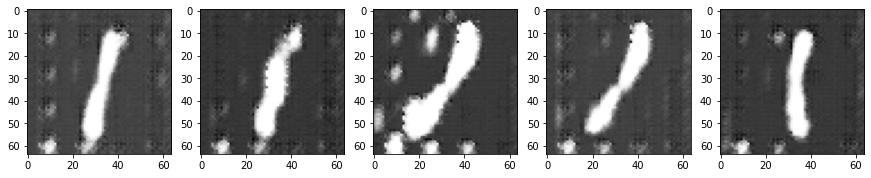

In [ ]:
z = torch.randn(8, 20).to(device).view(8, 20, 1, 1).to(device)
G = Generator().to(device)
D = Discriminator().to(device)
G.load_state_dict(torch.load(f'/content/drive/MyDrive/Colab Notebooks/GAN/ano_model_change/G_model_fold0.bin'))
D.load_state_dict(torch.load(f'/content/drive/MyDrive/Colab Notebooks/GAN/ano_model_change/D_model_fold0.bin'))

#任意のzに対して1の画像生成
fake_images = G(z)

# 出力
fig = plt.figure(figsize=(15, 3))
for i in range(0, 5):
    plt.subplot(1, 5, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

In [ ]:
def anomaly_score(input_image, fake_image, D):
  # Residual loss の計算
  residual_loss = torch.sum(torch.abs(input_image - fake_image), (1, 2, 3))

  # Discrimination loss の計算
  _, real_feature = D(input_image)
  _, fake_feature = D(fake_image)
  discrimination_loss = torch.sum(torch.abs(real_feature - fake_feature), (1))

  # 二つのlossを一定の割合で足し合わせる
  total_loss_by_image = 0.9 * residual_loss + 0.1 * discrimination_loss
  total_loss = total_loss_by_image.sum()

  return total_loss, total_loss_by_image, residual_loss

In [ ]:
# データローダの読み込みと画像の取得
test = df_test.iloc[:,1:].values.astype('float32')
# 28×28 の行列に変換
test = test.reshape(test.shape[0], 28, 28)
test_set = image_data_set(test)
test_loader = DataLoader(test_set, batch_size=10, shuffle=False)
bar = tqdm(enumerate(test_loader), total=len(test_loader))
for step, input_images in bar:
  input_images = input_images.to(device)
  # 潜在変数の初期化
  z = torch.randn(10, 20).to(device).view(10, 20, 1, 1)
  z.requires_grad = True
  # オプティマイザの定義
  z_optimizer = torch.optim.Adam([z], lr=1e-3)
  for epoch in range(5000):
    #z探し
    fake_images = G(z)
    loss, _, _ = anomaly_score(input_images, fake_images, D)
    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()

  #異常度の計算
  fake_images = G(z)
  if step==0:
    _, anomality, _ = anomaly_score(input_images, fake_images, D)
    anomality = anomality.cpu().detach().numpy()
  else:
    _, anomality_temp, _ = anomaly_score(input_images, fake_images, D)
    anomality_temp = anomality_temp.cpu().detach().numpy()
    anomality = np.concatenate([anomality, anomality_temp])


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
100%|██████████| 50/50 [59:36<00:00, 71.53s/it]


In [ ]:
anomality.shape

(500,)

In [ ]:
df_anomality=pd.DataFrame(anomality,columns = ['anomality'])

In [ ]:
df_test = pd.read_csv("/content/sample_data/mnist_test.csv")
df_test.rename(columns={'7': 'label'}, inplace=True)
# テストデータとして、2, 4の画像を合わせて600枚使用する
df_test = df_test.query("label in [1.0, 0.0]").head(500)
# ラベル(1列目)のみ取得
df_test = pd.DataFrame(df_test['label'].reset_index(drop=True))
df=pd.concat([df_test, df_anomality],axis=1)
df

,label,anomality
0,1,163181.437500
1,0,585769.687500
2,1,224093.812500
3,0,482254.562500
4,0,472134.062500
...,...,...
495,1,205259.062500
496,1,263535.562500
497,0,470570.875000
498,1,150544.453125


In [ ]:
df_1 = df[df["label"] == 1].reset_index(drop=True)
df_0 = df[df["label"] == 0].reset_index(drop=True)
df_hist=pd.concat([df_1['anomality'], df_0['anomality']],axis=1)

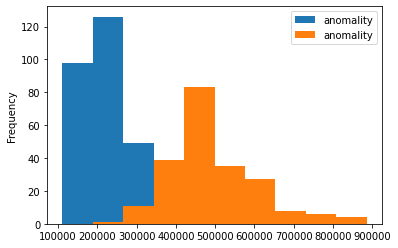

In [ ]:
histogram = df_hist.plot.hist()

In [ ]:
s=df['anomality'].min()
e=df['anomality'].max()

In [ ]:
#精度が上がるしきい値を探索
list_acc = []
for th in np.arange(s, e, 100.0):
  df=pd.concat([df_test, df_anomality],axis=1)
  df['judge'] = [1 if s > th else 0 for s in df['anomality']]
  df['label'] = [1 if s ==0 else 0 for s in df['label']]
  count=0
  for i,j in zip(df['label'],df['judge']):
    if i==j:
      count+=1
  accuracy=(count/len(df))*100
  list_acc.append((th, accuracy))

ths,acc = sorted(list_acc, key=lambda x:x[1], reverse=True)[0]
print(th,acc)

886603.5390625 95.6


In [ ]:
#以下auc-roc

In [ ]:
from sklearn.metrics import roc_auc_score

#精度が上がるしきい値を探索
list_auc = []
for th in np.arange(s, e, 100.0):
  df=pd.concat([df_test, df_anomality],axis=1)
  df['judge'] = [1 if s > th else 0 for s in df['anomality']]
  df['label'] = [1 if s ==0 else 0 for s in df['label']] 
  aucroc = roc_auc_score(df['label'].values, df['judge'].values)
  list_auc.append((th, aucroc))
ths,auc = sorted(list_auc, key=lambda x:x[1], reverse=True)[0]
print(ths,auc)

336203.5390625 0.954496438141298
